In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [229]:
#Importing training data
df_train = pd.read_csv('train.csv', index_col = 'Id')

In [230]:
df_train[df_train.columns[df_train.isnull().sum() > 0]].isna().mean()*100

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

In [231]:
#Drop columns with much null values
df_train = df_train.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1)

In [232]:
#Handling MSSubClass column which identifies the type of dwelling involved in the sale and has integer values
df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)

In [233]:
#Encoding and handling null values
df_encoded = pd.get_dummies(df_train, drop_first = True)
imputer = KNNImputer()
df_copy = df_encoded.copy()
df_without_nan = pd.DataFrame(imputer.fit_transform(df_encoded))
df_without_nan.columns = df_copy.columns

In [234]:
#Make train and test data and scale them separately
X = df_without_nan.drop('SalePrice', axis = 1)
y = df_without_nan['SalePrice']
scaler = RobustScaler()
target_scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
y_scaled = pd.DataFrame(target_scaler.fit_transform(pd.DataFrame(y)))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.20)

In [235]:
#Make a model
import keras
model = keras.Sequential([layers.BatchNormalization(input_shape = [X.shape[1]]),
                         layers.Dense(128, activation = 'relu'),
                         layers.BatchNormalization(),
                         layers.Dropout(0.3),
                         layers.Dense(128, activation = 'relu'),
                         layers.BatchNormalization(),
                         layers.Dropout(0.3),
                         layers.Dense(1)])
model.compile(loss = 'mae', optimizer = 'adam')

In [237]:
#Make a callback for the model to stop training when it stops improving
callback = EarlyStopping(min_delta = 0.0005,
                        patience = 20,
                        restore_best_weights = True)

In [238]:
#Fit the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   callbacks = [callback],
                   batch_size = 100,
                   epochs = 200)

Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1772 - val_loss: 0.6354
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9101 - val_loss: 0.6219
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 0.8181 - val_loss: 0.5878
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.8020 - val_loss: 0.5442
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.7374 - val_loss: 0.5120
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.7005 - val_loss: 0.4963
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.6290 - val_loss: 0.4511
Epoch 8/200
12/12 [==============================] - 0s 6ms/step - loss: 0.6380 - val_loss: 0.4017
Epoch 9/200
12/12 [==============================] - 0s 6ms/step - loss: 0.5963 - val_loss: 0.4571
Epoch 10/200
12/12 [==============================] - 0s 6ms/step - loss: 0.5739 - val_loss: 0.3964
Epoch 11

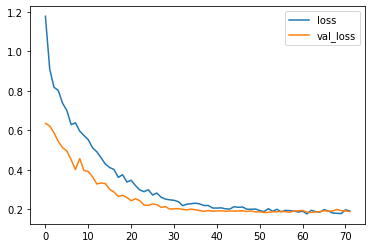

In [239]:
#Plotting the training loss (blue) and validation loss (orange)
pd.DataFrame(history.history).loc[:, ['loss', 'val_loss']].plot()

Training and validation losses reach similar values, the model seems to be fitted well

In [242]:
#Calculating mean squared error for model evaluation
y_pred = []
for x in model.predict(X_test):
    for y in x:
        y_pred.append(y)
from sklearn.metrics import mean_squared_error
import math
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))

MSE: 0.08463594785860108
